# Neural rendering optimization: Fit FLAME mesh for improved DECA results

Contents:


-    Pytorch 3D installation, FLAME and rendering examples;
-   Get image pairs, of face ground truth image and render prediction (DECA output);
-   Rendering and optimising/training FLAME for better single subject rendering (improving DECA results)



## Install all dependencies/requirements

### Install Pytorch3D

In [ ]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

device = 'cuda'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k    0  404k    0     0   917k      0 --:--:-- --:--:-- --:--:-- 6031k
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-rmkfym19
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-rmkfym19
  Running command git checkout -q 2bd65027ca5c3b87b77d4f05b8eacae58d8d106f
     |████████████████████████████████| 50 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 16.2 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.2-cp37-cp37m-linux_x86_64.whl size=31479108 sha256=934bfee361401e9128c565fe55caf8a79b118d01438c09aba61ca62dc79782a3
  Sto

In [ ]:
%cd /content
import torch
import numpy as np
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.structures import Meshes

from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLOrthographicCameras, 
    FoVPerspectiveCameras,
    PerspectiveCameras,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader,
    SoftPhongShader,
    SoftSilhouetteShader,
    BlendParams,
    TexturesVertex,
    TexturesUV
)

from pytorch3d.transforms import matrix_to_quaternion, quaternion_to_axis_angle, matrix_to_rotation_6d, axis_angle_to_matrix

### Install FLAME

In [ ]:
flame_model = '/content/drive/MyDrive/voca/FLAME2020.zip'
#!unzip [flame_model] -d /content/sample_data/
!unzip /content/drive/MyDrive/voca/FLAME2020.zip -d /content/sample_data/
!cp /content/sample_data/generic_model.pkl /content/DECA/data/

## Image (GT) and Render(Prediction) data

In [ ]:
from PIL import Image
import numpy as np

def load_img(img_path, downsample_factor=1):
    
    img = np.asarray(Image.open(img_path)) / 255
    img = img[::downsample_factor, ::downsample_factor, 0:3]

    img = torch.Tensor(img).unsqueeze(0)
          
    return img

In [ ]:
# Get data
!wget #dropbox link


##  Define and render an example mesh

### Define Camera View

In [ ]:
# Define camera matrix C
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    FoVPerspectiveCameras
)

R, T = look_at_view_transform(dist=3, elev=0, azim=0) # 0 elevation , and 0 azimuth
C = FoVPerspectiveCameras(device=device, R=R, T=T)

### Define Phong renderer

In [ ]:
# define renderer

from pytorch3d.renderer import  (
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    PointLights,
    Materials,
    RasterizationSettings,
    BlendParams
)

def get_phong_renderer(C_init, 
                      sigma=1.0e-4, 
                      gamma=1.0e-7, 
                      faces_per_pixel=50,
                      img_size=256):
  
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

  materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0)
  
  blend_params = BlendParams(background_color=(1,1,1), sigma=sigma, gamma=gamma)

  raster_settings = RasterizationSettings(
      image_size=img_size, 
      blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
      faces_per_pixel=faces_per_pixel, 
  )

  r = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=C_init,
          raster_settings=raster_settings
      ),
      shader=SoftPhongShader(
          device=device, 
          blend_params = blend_params,
          cameras=C_init,
          materials=materials,
          lights=lights
      )
  )

  return r

### Define Shilouette renderer



In [ ]:
def get_silhoutte_renderer(C_init, 
                      sigma=1.0e-7, 
                      gamma=1.0e-1, 
                      faces_per_pixel=50,
                      img_size=256):
  
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

  materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0)
  
  blend_params = BlendParams(background_color=(1,1,1), sigma=sigma, gamma=gamma)

  raster_settings = RasterizationSettings(
      image_size=img_size, 
      blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
      faces_per_pixel=faces_per_pixel, 
  )

  r = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=C_init, 
          raster_settings=raster_settings
      ),
      shader=SoftSilhouetteShader(blend_params=blend_params)
  )

  return r

### Display example render via phong renderer

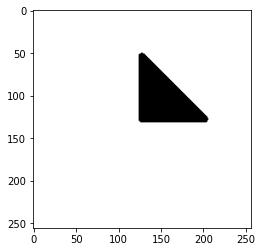

In [ ]:
example_obj = load_obj() # load mesh object
r = get_phong_renderer(C, sigma=1.0e-4, gamma=1.0e-7, faces_per_pixel=1) # this returns a MeshRenderer object
I = r(example_obj.to(device)).detach().cpu().numpy()
plt.imshow(I[0, :, :, 0:3])

## Get Image Pairs

### Utility Function

In [ ]:
# auxiliary function: get render and ground truth images

def get_image_pair(azimuth, renderer, silh=False):

  I_gt = load_img(os.path.join(data_path, '%05d.png' % azimuth)).to(device)

  V = smplx_model.forward(body_pose=axis_angle_to_matrix(body_pose),
                      global_orient=axis_angle_to_matrix(global_orient),
                      transl=transl,
                      betas=betas)['vertices']
  T = TexturesUV(maps=T_uv, faces_uvs=F_uv, verts_uvs=V_uv)
  X = Meshes(V, F, T)

  R, T = look_at_view_transform(dist=3, elev=0, azim=azimuth)
  C = FoVOrthographicCameras(device=device, R=R, T=T)
  I_pred = renderer(X, cameras=C)

  if silh:
    I_gt = I_gt[:, :, :, 2]
    I_gt[I_gt==1] = 0
    I_gt[I_gt!=0] = 1
    I_pred = I_pred[:, :, :, 3]
  else:
    I_pred = I_pred[:, :, :, 0:3]
    
  return I_pred, I_gt

### Display training image pairs e.g GT & Prediction

In [ ]:
renderer_phong = get_phong_renderer(C, sigma=1.0e-7, gamma=1.0e-7, 
                                    faces_per_pixel=1, img_size=256)

azimuth = 90 #np.random.choice(azimuths)

I_pred, I_gt = get_image_pair(azimuth, renderer_phong, silh=False)

I_merged = torch.cat([I_pred, I_gt], 2)[0].detach().cpu()

plt.figure(figsize=(10, 20))
plt.imshow(I_merged)

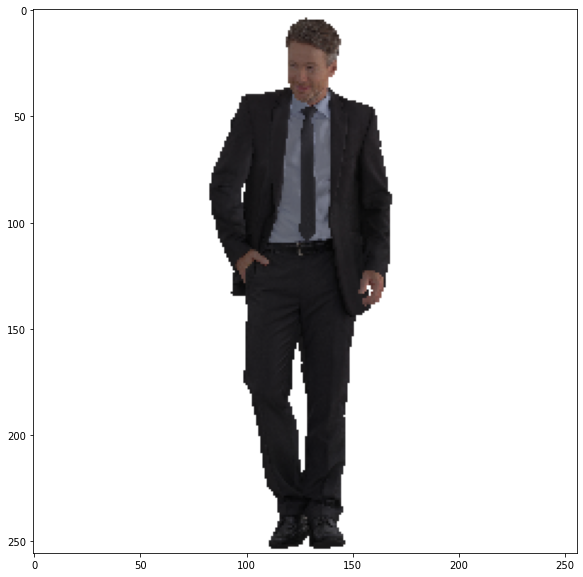

### Visualize Training renders (DECA results)

In [ ]:
# Visualize training renders (DECA predictions)
%cd /content/renders
!ffmpeg -framerate 10 -pattern_type glob -i '*.png' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  /content/training_data.mp4
%cd /content

/content/renders
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-lib

In [ ]:

from IPython.display import HTML
from base64 import b64encode
mp4 = open('training_data.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Optimization/Training of FLAME

In [ ]:
# the path to your downloaded SMPLX_MODEL
!unzip /content/gdrive/MyDrive/datasets/smplx/models_smplx_v1_1.zip -d /content/sample_data/

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import smplx
from pytorch3d.transforms import axis_angle_to_matrix

smplx_model_path = '/content/sample_data/models/smplx'
smplx_uv_map_path = '/content/smplx_uv.obj'

smplx_model = smplx.SMPLXLayer(smplx_model_path, gender='neutral').to(device)
print(smplx_model)
F = torch.Tensor(smplx_model.faces.astype('int')).type(torch.int32).unsqueeze(0)
F = F.to(device)

# texture map
_, faces, properties = load_obj(smplx_uv_map_path, load_textures=False) # set to False
V_uv = properties.verts_uvs.unsqueeze(0).to(device)
F_uv = faces.textures_idx.unsqueeze(0).type(torch.long).to(device)
T_uv = torch.ones([1, 128, 128, 3]).to(device)

# initialise SMPL-x parameters 
body_pose = torch.zeros([1, 21, 3]).to(device)
transl = torch.Tensor([[0, 0.5, 0]]).to(device)
global_orient = torch.Tensor([[0, np.pi/2, 0]]).to(device)
betas = torch.zeros([1, 10]).to(device)

Mounted at /content/gdrive


ModuleNotFoundError: ignored

### Silhouette Optimization

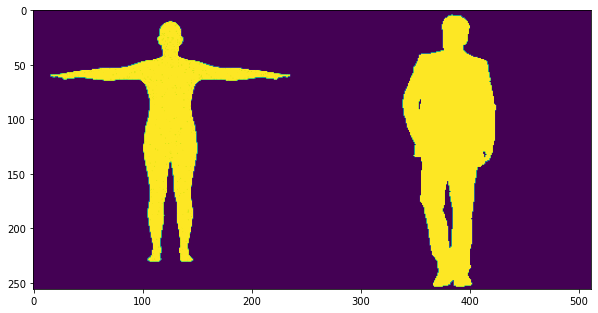

In [ ]:
## Silhouette Optimization

renderer_silh = get_silhoutte_renderer(C, sigma=1.0e-7, gamma=1.0e-1, 
                                       faces_per_pixel=50, img_size=256)
 
I_pred, I_gt = get_image_pair(90, renderer_silh, silh=True)

I_merged = torch.cat([I_pred, I_gt], 2)[0].detach().cpu()
plt.figure(figsize=(10, 20))
plt.imshow(I_merged)

In [ ]:
body_pose = torch.nn.Parameter(body_pose, requires_grad=True)
transl = torch.nn.Parameter(transl, requires_grad=True)
global_orient = torch.nn.Parameter(global_orient, requires_grad=True)
betas = torch.nn.Parameter(betas, requires_grad=True)

body_opt = torch.optim.Adam([body_pose, transl, global_orient, betas], lr=1.0e-2)
body_sched =  torch.optim.lr_scheduler.ReduceLROnPlateau(body_opt, 
                                                         patience=2,
                                                         verbose=True)
crit = torch.nn.L1Loss()

In [ ]:
silh_log_dir = '/content/logs_silh_optimisation'
!rm -rf $silh_log_dir
!mkdir $silh_log_dir

n_epochs = 50

for epoch_id in range(0, n_epochs):

  # render current results
  I_pred, I_gt = get_image_pair(90, renderer_silh, silh=True)
  I_merged = torch.cat([I_pred, I_gt], 2)[0].detach().cpu()
  plt.imsave(os.path.join(silh_log_dir, '%05d.png' % epoch_id), I_merged)

  train_frames = np.random.choice(azimuths, len(azimuths), replace=False)
  total_loss = 0

  for azim in train_frames:

    I_pred, I_gt = get_image_pair(azim, renderer_silh, silh=True)

    loss = crit(I_gt.to(device), I_pred)
    total_loss += float(loss)

    body_opt.zero_grad()
    loss.backward()
    body_opt.step()

  print("Total L1 loss: %f" % total_loss)
  body_sched.step(total_loss)

In [ ]:
# @title Generate optimisation video
%cd /content/logs_silh_optimisation
!ffmpeg -framerate 1 -pattern_type glob -i '*.png' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  /content/silh_video.mp4
%cd /content

/content/logs_silh_optimisation
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxm

In [ ]:
# @title Visualise silhouette optimisation process
from IPython.display import HTML
from base64 import b64encode
mp4 = open('silh_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

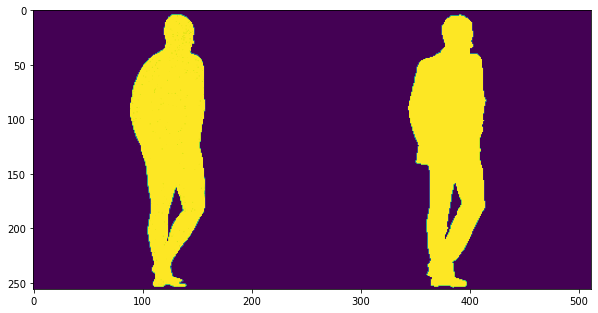

In [ ]:
renderer_silh = get_silhoutte_renderer(C, sigma=1.0e-7, gamma=1.0e-1, 
                                       faces_per_pixel=50, img_size=256)
 
I_pred, I_gt = get_image_pair(azim, renderer_silh, silh=True)

I_merged = torch.cat([I_pred, I_gt], 2)[0].detach().cpu()
plt.figure(figsize=(10, 20))
plt.imshow(I_merged)

In [ ]:
# @title generate video

silh_res_dir = '/content/results_silh_optimisation'

!rm -rf $silh_res_dir
!mkdir $silh_res_dir

for azim in azimuths:

  I_pred, I_gt = get_image_pair(azim, renderer_phong, silh=False)
  I_merged = torch.cat([I_pred, I_gt], 2)[0].detach().cpu().numpy()
  plt.imsave(os.path.join(silh_res_dir, '%05d.png' % azim), I_merged)

%cd $silh_res_dir
!ffmpeg -framerate 10 -pattern_type glob -i '*.png' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  /content/silh_video_res.mp4
%cd /content



/content/results_silh_optimisation
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-li

In [ ]:
# @title Visualise optimised SMPL-X mesh
from IPython.display import HTML
from base64 import b64encode
mp4 = open('silh_video_res.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Texture Optimization

In [ ]:
rgb_log_dir = '/content/logs_phong_optimisation'
!rm -rf $rgb_log_dir
!mkdir $rgb_log_dir

T_uv = torch.nn.Parameter(T_uv, requires_grad=True)

body_opt = torch.optim.Adam([body_pose, transl, global_orient, betas], 
                            lr=1.0e-4)
body_sched =  torch.optim.lr_scheduler.ReduceLROnPlateau(body_opt, 
                                                         patience=2,
                                                         verbose=True)

uv_opt = torch.optim.Adam([T_uv], lr=1.0e-2)
uv_sched =  torch.optim.lr_scheduler.ReduceLROnPlateau(uv_opt, 
                                                         patience=2,
                                                         verbose=True)

crit = torch.nn.L1Loss()

n_epochs = 50

for epoch_id in range(0, n_epochs):

  I_pred, I_gt = get_image_pair(90, renderer_phong, silh=False)
  I_merged = torch.cat([I_pred, I_gt], 2)[0].detach().cpu().clip(0, 1).numpy()
  plt.imsave(os.path.join(rgb_log_dir, '%05d.png' % epoch_id), I_merged)
  
  train_frames = np.random.choice(azimuths, len(azimuths), replace=False)

  total_loss = 0

  for azim in train_frames:

    I_pred, I_gt = get_image_pair(azim, renderer_phong, silh=False)

    loss = crit(I_gt.to(device), I_pred)
    total_loss += float(loss)

    body_opt.zero_grad()
    uv_opt.zero_grad()
    loss.backward()
    uv_opt.step()
    body_opt.step()

  print("Total L1 loss: %f" % total_loss)
  body_sched.step(total_loss)
  uv_sched.step(total_loss)


Total L1 loss: 4.527597
Total L1 loss: 2.553882
Total L1 loss: 1.820440
Total L1 loss: 1.721617
Total L1 loss: 1.659495
Total L1 loss: 1.616642
Total L1 loss: 1.574298
Total L1 loss: 1.537526
Total L1 loss: 1.496410
Total L1 loss: 1.457219
Total L1 loss: 1.433312
Total L1 loss: 1.409341
Total L1 loss: 1.391301
Total L1 loss: 1.375534
Total L1 loss: 1.364780
Total L1 loss: 1.345792
Total L1 loss: 1.327670
Total L1 loss: 1.317181
Total L1 loss: 1.314236
Total L1 loss: 1.305634
Total L1 loss: 1.293211
Total L1 loss: 1.296743
Total L1 loss: 1.288517
Total L1 loss: 1.289002
Total L1 loss: 1.283759
Total L1 loss: 1.277759
Total L1 loss: 1.277332
Total L1 loss: 1.270704
Total L1 loss: 1.271294
Total L1 loss: 1.268891
Total L1 loss: 1.261933
Total L1 loss: 1.256852
Total L1 loss: 1.258578
Total L1 loss: 1.261340
Total L1 loss: 1.252719
Total L1 loss: 1.250261
Total L1 loss: 1.246187
Total L1 loss: 1.243890
Total L1 loss: 1.238077
Total L1 loss: 1.232685
Total L1 loss: 1.233002
Total L1 loss: 1

In [ ]:
# @title generate texture optimisation video
%cd /content/logs_phong_optimisation
!ffmpeg -framerate 1 -pattern_type glob -i '*.png' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  /content/rgb_video.mp4
%cd /content

/content/logs_phong_optimisation
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libx

In [ ]:
# @title Show texture optimisation process
from IPython.display import HTML
from base64 import b64encode
mp4 = open('rgb_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# @title generate video

silh_res_dir = '/content/results_phong_optimisation'

!rm -rf $silh_res_dir
!mkdir $silh_res_dir

for azim in azimuths:

  I_pred, I_gt = get_image_pair(azim, renderer_phong, silh=False)
  I_merged = torch.cat([I_pred, I_gt], 2)[0].detach().cpu().clip(0, 1).numpy()
  plt.imsave(os.path.join(silh_res_dir, '%05d.png' % azim), I_merged)

%cd $silh_res_dir
!ffmpeg -framerate 10 -pattern_type glob -i '*.png' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  /content/phong_video_res.mp4
%cd /content

/content/results_phong_optimisation
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-l

In [ ]:
# @title Show final optimisation results
from IPython.display import HTML
from base64 import b64encode
mp4 = open('phong_video_res.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)